## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [1]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from utils import plot_images
import data_utils as du
%matplotlib inline

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


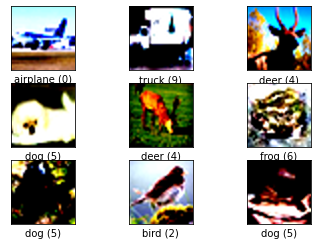

In [2]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader()

In [3]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.maxPool1 = nn.MaxPool2d(2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchNorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.batchNorm4 = nn.BatchNorm2d(64)
        self.maxPool2 = nn.MaxPool2d(2, stride=2)
        
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchNorm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.batchNorm6 = nn.BatchNorm2d(128)
        self.maxPool3 = nn.MaxPool2d(2, stride=2)
        
        self.fc1 = nn.Linear(2048, 10)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################

        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = F.relu(x)
        x = self.maxPool1(x)
        
        x = self.conv3(x)
        x = self.batchNorm3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.batchNorm4(x)
        x = F.relu(x)
        x = self.maxPool2(x)
        
        x = self.conv5(x)
        x = self.batchNorm5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.batchNorm6(x)
        x = F.relu(x)
        x = self.maxPool3(x)
        
        x = torch.flatten(x, start_dim = 1)
        
        x = self.fc1(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def predict(self, x):
        outputs = self.forward(x)
        return torch.argmax(F.softmax(outputs).data, 1)

In [16]:
net = ConvNet()
print(net)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm5): BatchNorm2d(128, eps=1e-05, 

In [10]:
#Overfit a small batch

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05)
dataiter = iter(trainloader)
images, labels = dataiter.next()
epochs = 500

for e in range(epochs):

    #Reset the gradient
    optimizer.zero_grad()

    # Feedforward pass
    output = net.forward(images)

    # Compute the loss
    loss = criterion(output, labels)

     # Compute the gradient
    loss.backward()

    # Update the weights
    optimizer.step()
    net.eval()
    accuracy = torch.mean((net.predict(images) == labels).to(torch.float32))
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Test accuracy: {:.4f}..".format(accuracy)
         )


/home/martin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/500.. Test accuracy: 0.1250..
Epoch: 2/500.. Test accuracy: 0.1250..
Epoch: 3/500.. Test accuracy: 0.1250..
Epoch: 4/500.. Test accuracy: 0.1250..
Epoch: 5/500.. Test accuracy: 0.1250..
Epoch: 6/500.. Test accuracy: 0.1250..
Epoch: 7/500.. Test accuracy: 0.1250..
Epoch: 8/500.. Test accuracy: 0.1250..
Epoch: 9/500.. Test accuracy: 0.1250..
Epoch: 10/500.. Test accuracy: 0.1250..
Epoch: 11/500.. Test accuracy: 0.1250..
Epoch: 12/500.. Test accuracy: 0.1250..
Epoch: 13/500.. Test accuracy: 0.1250..
Epoch: 14/500.. Test accuracy: 0.1562..
Epoch: 15/500.. Test accuracy: 0.1562..
Epoch: 16/500.. Test accuracy: 0.1719..
Epoch: 17/500.. Test accuracy: 0.1719..
Epoch: 18/500.. Test accuracy: 0.1875..
Epoch: 19/500.. Test accuracy: 0.1875..
Epoch: 20/500.. Test accuracy: 0.2031..
Epoch: 21/500.. Test accuracy: 0.2188..
Epoch: 22/500.. Test accuracy: 0.1875..
Epoch: 23/500.. Test accuracy: 0.2031..
Epoch: 24/500.. Test accuracy: 0.2188..
Epoch: 25/500.. Test accuracy: 0.2188..
Epoch: 26

KeyboardInterrupt: 

In [17]:
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.2
epochs = 100
steps = 0
running_loss = 0
print_every = 20
for e in range(epochs):
    if not e % 10:
        learning_rate /= 2
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, weight_decay = 1e-5)
        
    start = time.time()
    for images, labels in iter(trainloader):
        
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #                                                                            #
        ################################################################################
        #Reset the gradient
        optimizer.zero_grad()
        
        # Feedforward pass
        output = net.forward(images)
        
        # Compute the loss
        loss = criterion(output, labels)
        
         # Compute the gradient
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            net.eval()
            stop = time.time()
            # Test accuracy
            accuracy = 0
            with torch.no_grad():
                for ii, (images, labels) in enumerate(valloader):

                    ################################################################################
                    # TODO:                                                                        #
                    # Calculate the accuracy                                                       #
                    ################################################################################
                    accuracy += torch.mean((net.predict(images) == labels).to(torch.float32)) 
                    ################################################################################
                    #                              END OF YOUR CODE                                #
                    ################################################################################
                print("Epoch: {}/{}..".format(e+1, epochs),
                      "Learning rate {}".format(learning_rate),
                      "Loss: {:.4f}..".format(running_loss/print_every),
                      "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                      "{:.4f} s/batch".format((stop - start)/print_every)
                     )
                running_loss = 0
                start = time.time()    

/home/martin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/100.. Learning rate 0.1 Loss: 7.0473.. Test accuracy: 0.1643.. 0.2812 s/batch
Epoch: 1/100.. Learning rate 0.1 Loss: 2.3147.. Test accuracy: 0.1748.. 0.2219 s/batch
Epoch: 1/100.. Learning rate 0.1 Loss: 2.1951.. Test accuracy: 0.2383.. 0.2123 s/batch
Epoch: 1/100.. Learning rate 0.1 Loss: 2.1340.. Test accuracy: 0.2045.. 0.2132 s/batch
Epoch: 1/100.. Learning rate 0.1 Loss: 2.1075.. Test accuracy: 0.2135.. 0.2146 s/batch
Epoch: 1/100.. Learning rate 0.1 Loss: 2.0604.. Test accuracy: 0.2537.. 0.2147 s/batch
Epoch: 1/100.. Learning rate 0.1 Loss: 2.0272.. Test accuracy: 0.2693.. 0.2149 s/batch
Epoch: 1/100.. Learning rate 0.1 Loss: 2.0018.. Test accuracy: 0.3133.. 0.2136 s/batch
Epoch: 1/100.. Learning rate 0.1 Loss: 1.9192.. Test accuracy: 0.3104.. 0.2133 s/batch
Epoch: 1/100.. Learning rate 0.1 Loss: 2.0124.. Test accuracy: 0.2783.. 0.2158 s/batch
Epoch: 1/100.. Learning rate 0.1 Loss: 1.9557.. Test accuracy: 0.3389.. 0.2160 s/batch
Epoch: 1/100.. Learning rate 0.1 Loss: 1.91

Epoch: 3/100.. Learning rate 0.1 Loss: 1.2076.. Test accuracy: 0.5590.. 0.2229 s/batch
Epoch: 3/100.. Learning rate 0.1 Loss: 1.2992.. Test accuracy: 0.5537.. 0.2153 s/batch
Epoch: 3/100.. Learning rate 0.1 Loss: 1.2253.. Test accuracy: 0.5527.. 0.2174 s/batch
Epoch: 3/100.. Learning rate 0.1 Loss: 1.1985.. Test accuracy: 0.5646.. 0.2150 s/batch
Epoch: 3/100.. Learning rate 0.1 Loss: 1.1801.. Test accuracy: 0.5797.. 0.2144 s/batch
Epoch: 3/100.. Learning rate 0.1 Loss: 1.2321.. Test accuracy: 0.5836.. 0.2154 s/batch
Epoch: 3/100.. Learning rate 0.1 Loss: 1.2811.. Test accuracy: 0.5613.. 0.2167 s/batch
Epoch: 3/100.. Learning rate 0.1 Loss: 1.1794.. Test accuracy: 0.5668.. 0.2160 s/batch
Epoch: 3/100.. Learning rate 0.1 Loss: 1.1937.. Test accuracy: 0.5445.. 0.2192 s/batch
Epoch: 3/100.. Learning rate 0.1 Loss: 1.2256.. Test accuracy: 0.5572.. 0.2155 s/batch
Epoch: 3/100.. Learning rate 0.1 Loss: 1.2017.. Test accuracy: 0.5514.. 0.2146 s/batch
Epoch: 3/100.. Learning rate 0.1 Loss: 1.28

Epoch: 5/100.. Learning rate 0.1 Loss: 0.9285.. Test accuracy: 0.6396.. 0.2158 s/batch
Epoch: 6/100.. Learning rate 0.1 Loss: 0.8956.. Test accuracy: 0.6457.. 0.1210 s/batch
Epoch: 6/100.. Learning rate 0.1 Loss: 0.8639.. Test accuracy: 0.6537.. 0.2144 s/batch
Epoch: 6/100.. Learning rate 0.1 Loss: 0.8402.. Test accuracy: 0.6480.. 0.2176 s/batch
Epoch: 6/100.. Learning rate 0.1 Loss: 0.8305.. Test accuracy: 0.6521.. 0.2163 s/batch
Epoch: 6/100.. Learning rate 0.1 Loss: 0.8584.. Test accuracy: 0.6555.. 0.2160 s/batch
Epoch: 6/100.. Learning rate 0.1 Loss: 0.8293.. Test accuracy: 0.6693.. 0.2149 s/batch
Epoch: 6/100.. Learning rate 0.1 Loss: 0.8822.. Test accuracy: 0.6539.. 0.2162 s/batch
Epoch: 6/100.. Learning rate 0.1 Loss: 0.8652.. Test accuracy: 0.6508.. 0.2151 s/batch
Epoch: 6/100.. Learning rate 0.1 Loss: 0.8867.. Test accuracy: 0.6605.. 0.2152 s/batch
Epoch: 6/100.. Learning rate 0.1 Loss: 0.8664.. Test accuracy: 0.6791.. 0.2206 s/batch
Epoch: 6/100.. Learning rate 0.1 Loss: 0.86

Epoch: 8/100.. Learning rate 0.1 Loss: 0.6634.. Test accuracy: 0.7152.. 0.2158 s/batch
Epoch: 8/100.. Learning rate 0.1 Loss: 0.7130.. Test accuracy: 0.7150.. 0.2158 s/batch
Epoch: 8/100.. Learning rate 0.1 Loss: 0.6203.. Test accuracy: 0.6949.. 0.2168 s/batch
Epoch: 8/100.. Learning rate 0.1 Loss: 0.6786.. Test accuracy: 0.7109.. 0.2158 s/batch
Epoch: 8/100.. Learning rate 0.1 Loss: 0.7085.. Test accuracy: 0.7252.. 0.2148 s/batch
Epoch: 8/100.. Learning rate 0.1 Loss: 0.6413.. Test accuracy: 0.7215.. 0.2172 s/batch
Epoch: 8/100.. Learning rate 0.1 Loss: 0.6561.. Test accuracy: 0.7262.. 0.2155 s/batch
Epoch: 8/100.. Learning rate 0.1 Loss: 0.7200.. Test accuracy: 0.7211.. 0.2168 s/batch
Epoch: 8/100.. Learning rate 0.1 Loss: 0.6862.. Test accuracy: 0.7301.. 0.2146 s/batch
Epoch: 8/100.. Learning rate 0.1 Loss: 0.6674.. Test accuracy: 0.7137.. 0.2143 s/batch
Epoch: 8/100.. Learning rate 0.1 Loss: 0.6715.. Test accuracy: 0.7176.. 0.2168 s/batch
Epoch: 8/100.. Learning rate 0.1 Loss: 0.74

Epoch: 10/100.. Learning rate 0.1 Loss: 0.5772.. Test accuracy: 0.7498.. 0.2150 s/batch
Epoch: 10/100.. Learning rate 0.1 Loss: 0.6366.. Test accuracy: 0.7437.. 0.2150 s/batch
Epoch: 10/100.. Learning rate 0.1 Loss: 0.5729.. Test accuracy: 0.7338.. 0.2148 s/batch
Epoch: 10/100.. Learning rate 0.1 Loss: 0.6176.. Test accuracy: 0.7531.. 0.2104 s/batch
Epoch: 11/100.. Learning rate 0.05 Loss: 0.4615.. Test accuracy: 0.7590.. 0.2278 s/batch
Epoch: 11/100.. Learning rate 0.05 Loss: 0.4127.. Test accuracy: 0.7574.. 0.2164 s/batch
Epoch: 11/100.. Learning rate 0.05 Loss: 0.3396.. Test accuracy: 0.7631.. 0.2150 s/batch
Epoch: 11/100.. Learning rate 0.05 Loss: 0.4050.. Test accuracy: 0.7717.. 0.2146 s/batch
Epoch: 11/100.. Learning rate 0.05 Loss: 0.4352.. Test accuracy: 0.7590.. 0.2174 s/batch
Epoch: 11/100.. Learning rate 0.05 Loss: 0.3795.. Test accuracy: 0.7613.. 0.2156 s/batch
Epoch: 11/100.. Learning rate 0.05 Loss: 0.3828.. Test accuracy: 0.7633.. 0.2273 s/batch
Epoch: 11/100.. Learning 

Epoch: 13/100.. Learning rate 0.05 Loss: 0.3132.. Test accuracy: 0.7496.. 0.2151 s/batch
Epoch: 13/100.. Learning rate 0.05 Loss: 0.2948.. Test accuracy: 0.7480.. 0.2244 s/batch
Epoch: 13/100.. Learning rate 0.05 Loss: 0.2691.. Test accuracy: 0.7504.. 0.2194 s/batch
Epoch: 13/100.. Learning rate 0.05 Loss: 0.2793.. Test accuracy: 0.7545.. 0.2154 s/batch
Epoch: 13/100.. Learning rate 0.05 Loss: 0.2923.. Test accuracy: 0.7443.. 0.2153 s/batch
Epoch: 13/100.. Learning rate 0.05 Loss: 0.2929.. Test accuracy: 0.7486.. 0.2146 s/batch
Epoch: 13/100.. Learning rate 0.05 Loss: 0.3388.. Test accuracy: 0.7471.. 0.2146 s/batch
Epoch: 13/100.. Learning rate 0.05 Loss: 0.2831.. Test accuracy: 0.7455.. 0.2155 s/batch
Epoch: 13/100.. Learning rate 0.05 Loss: 0.3308.. Test accuracy: 0.7465.. 0.2174 s/batch
Epoch: 13/100.. Learning rate 0.05 Loss: 0.3135.. Test accuracy: 0.7422.. 0.2149 s/batch
Epoch: 13/100.. Learning rate 0.05 Loss: 0.3133.. Test accuracy: 0.7330.. 0.2157 s/batch
Epoch: 13/100.. Learn

Epoch: 15/100.. Learning rate 0.05 Loss: 0.2836.. Test accuracy: 0.7486.. 0.2178 s/batch
Epoch: 15/100.. Learning rate 0.05 Loss: 0.2151.. Test accuracy: 0.7412.. 0.2164 s/batch
Epoch: 15/100.. Learning rate 0.05 Loss: 0.2498.. Test accuracy: 0.7652.. 0.2150 s/batch
Epoch: 15/100.. Learning rate 0.05 Loss: 0.2751.. Test accuracy: 0.7498.. 0.2183 s/batch
Epoch: 15/100.. Learning rate 0.05 Loss: 0.2561.. Test accuracy: 0.7451.. 0.2148 s/batch
Epoch: 15/100.. Learning rate 0.05 Loss: 0.2605.. Test accuracy: 0.7678.. 0.2191 s/batch
Epoch: 15/100.. Learning rate 0.05 Loss: 0.2611.. Test accuracy: 0.7668.. 0.2163 s/batch
Epoch: 15/100.. Learning rate 0.05 Loss: 0.2803.. Test accuracy: 0.7264.. 0.2139 s/batch
Epoch: 15/100.. Learning rate 0.05 Loss: 0.2408.. Test accuracy: 0.7512.. 0.2163 s/batch
Epoch: 16/100.. Learning rate 0.05 Loss: 0.2431.. Test accuracy: 0.7670.. 0.1204 s/batch
Epoch: 16/100.. Learning rate 0.05 Loss: 0.1502.. Test accuracy: 0.7502.. 0.2172 s/batch
Epoch: 16/100.. Learn

Epoch: 18/100.. Learning rate 0.05 Loss: 0.1477.. Test accuracy: 0.7520.. 0.2165 s/batch
Epoch: 18/100.. Learning rate 0.05 Loss: 0.1610.. Test accuracy: 0.7529.. 0.2158 s/batch
Epoch: 18/100.. Learning rate 0.05 Loss: 0.1591.. Test accuracy: 0.7570.. 0.2147 s/batch
Epoch: 18/100.. Learning rate 0.05 Loss: 0.1356.. Test accuracy: 0.7500.. 0.2152 s/batch
Epoch: 18/100.. Learning rate 0.05 Loss: 0.1307.. Test accuracy: 0.7543.. 0.2242 s/batch
Epoch: 18/100.. Learning rate 0.05 Loss: 0.1642.. Test accuracy: 0.7471.. 0.2153 s/batch
Epoch: 18/100.. Learning rate 0.05 Loss: 0.1775.. Test accuracy: 0.7602.. 0.2155 s/batch
Epoch: 18/100.. Learning rate 0.05 Loss: 0.1473.. Test accuracy: 0.7617.. 0.2166 s/batch
Epoch: 18/100.. Learning rate 0.05 Loss: 0.1434.. Test accuracy: 0.7502.. 0.2153 s/batch
Epoch: 18/100.. Learning rate 0.05 Loss: 0.1739.. Test accuracy: 0.7463.. 0.2216 s/batch
Epoch: 18/100.. Learning rate 0.05 Loss: 0.1813.. Test accuracy: 0.7559.. 0.2691 s/batch
Epoch: 18/100.. Learn

Epoch: 20/100.. Learning rate 0.05 Loss: 0.1879.. Test accuracy: 0.7457.. 0.2961 s/batch
Epoch: 20/100.. Learning rate 0.05 Loss: 0.1562.. Test accuracy: 0.7537.. 0.3381 s/batch
Epoch: 20/100.. Learning rate 0.05 Loss: 0.1340.. Test accuracy: 0.7492.. 0.3088 s/batch
Epoch: 20/100.. Learning rate 0.05 Loss: 0.1337.. Test accuracy: 0.7375.. 0.2305 s/batch
Epoch: 20/100.. Learning rate 0.05 Loss: 0.1525.. Test accuracy: 0.7463.. 0.2216 s/batch
Epoch: 20/100.. Learning rate 0.05 Loss: 0.1539.. Test accuracy: 0.7416.. 0.2251 s/batch
Epoch: 20/100.. Learning rate 0.05 Loss: 0.1581.. Test accuracy: 0.7572.. 0.2273 s/batch
Epoch: 20/100.. Learning rate 0.05 Loss: 0.1928.. Test accuracy: 0.7516.. 0.3056 s/batch
Epoch: 20/100.. Learning rate 0.05 Loss: 0.1479.. Test accuracy: 0.7533.. 0.2811 s/batch
Epoch: 20/100.. Learning rate 0.05 Loss: 0.1859.. Test accuracy: 0.7623.. 0.2255 s/batch
Epoch: 20/100.. Learning rate 0.05 Loss: 0.1841.. Test accuracy: 0.7420.. 0.2381 s/batch
Epoch: 20/100.. Learn

Epoch: 23/100.. Learning rate 0.025 Loss: 0.0036.. Test accuracy: 0.7811.. 0.2605 s/batch
Epoch: 23/100.. Learning rate 0.025 Loss: 0.0044.. Test accuracy: 0.7771.. 0.2490 s/batch
Epoch: 23/100.. Learning rate 0.025 Loss: 0.0041.. Test accuracy: 0.7734.. 0.2534 s/batch
Epoch: 23/100.. Learning rate 0.025 Loss: 0.0039.. Test accuracy: 0.7723.. 0.2402 s/batch
Epoch: 23/100.. Learning rate 0.025 Loss: 0.0035.. Test accuracy: 0.7725.. 0.2625 s/batch
Epoch: 23/100.. Learning rate 0.025 Loss: 0.0038.. Test accuracy: 0.7777.. 0.2452 s/batch
Epoch: 23/100.. Learning rate 0.025 Loss: 0.0031.. Test accuracy: 0.7777.. 0.2530 s/batch
Epoch: 23/100.. Learning rate 0.025 Loss: 0.0031.. Test accuracy: 0.7770.. 0.2289 s/batch
Epoch: 23/100.. Learning rate 0.025 Loss: 0.0031.. Test accuracy: 0.7742.. 0.2380 s/batch
Epoch: 23/100.. Learning rate 0.025 Loss: 0.0039.. Test accuracy: 0.7762.. 0.2454 s/batch
Epoch: 23/100.. Learning rate 0.025 Loss: 0.0023.. Test accuracy: 0.7768.. 0.2401 s/batch
Epoch: 23/

Epoch: 25/100.. Learning rate 0.025 Loss: 0.0012.. Test accuracy: 0.7793.. 0.2386 s/batch
Epoch: 25/100.. Learning rate 0.025 Loss: 0.0015.. Test accuracy: 0.7785.. 0.2345 s/batch
Epoch: 25/100.. Learning rate 0.025 Loss: 0.0012.. Test accuracy: 0.7779.. 0.2474 s/batch
Epoch: 25/100.. Learning rate 0.025 Loss: 0.0011.. Test accuracy: 0.7740.. 0.2470 s/batch
Epoch: 25/100.. Learning rate 0.025 Loss: 0.0011.. Test accuracy: 0.7811.. 0.2638 s/batch
Epoch: 25/100.. Learning rate 0.025 Loss: 0.0012.. Test accuracy: 0.7770.. 0.2457 s/batch
Epoch: 25/100.. Learning rate 0.025 Loss: 0.0010.. Test accuracy: 0.7779.. 0.2557 s/batch
Epoch: 25/100.. Learning rate 0.025 Loss: 0.0010.. Test accuracy: 0.7779.. 0.2320 s/batch
Epoch: 25/100.. Learning rate 0.025 Loss: 0.0011.. Test accuracy: 0.7803.. 0.2494 s/batch
Epoch: 25/100.. Learning rate 0.025 Loss: 0.0011.. Test accuracy: 0.7803.. 0.2409 s/batch
Epoch: 25/100.. Learning rate 0.025 Loss: 0.0012.. Test accuracy: 0.7826.. 0.2438 s/batch
Epoch: 25/

Epoch: 27/100.. Learning rate 0.025 Loss: 0.0006.. Test accuracy: 0.7791.. 0.2681 s/batch
Epoch: 27/100.. Learning rate 0.025 Loss: 0.0008.. Test accuracy: 0.7779.. 0.2409 s/batch
Epoch: 27/100.. Learning rate 0.025 Loss: 0.0006.. Test accuracy: 0.7766.. 0.2535 s/batch
Epoch: 27/100.. Learning rate 0.025 Loss: 0.0006.. Test accuracy: 0.7748.. 0.2538 s/batch
Epoch: 27/100.. Learning rate 0.025 Loss: 0.0008.. Test accuracy: 0.7750.. 0.2623 s/batch
Epoch: 27/100.. Learning rate 0.025 Loss: 0.0007.. Test accuracy: 0.7824.. 0.2600 s/batch
Epoch: 27/100.. Learning rate 0.025 Loss: 0.0008.. Test accuracy: 0.7805.. 0.2576 s/batch
Epoch: 28/100.. Learning rate 0.025 Loss: 0.0006.. Test accuracy: 0.7811.. 0.2547 s/batch
Epoch: 28/100.. Learning rate 0.025 Loss: 0.0006.. Test accuracy: 0.7826.. 0.2648 s/batch
Epoch: 28/100.. Learning rate 0.025 Loss: 0.0006.. Test accuracy: 0.7771.. 0.2694 s/batch
Epoch: 28/100.. Learning rate 0.025 Loss: 0.0006.. Test accuracy: 0.7783.. 0.2735 s/batch
Epoch: 28/

Epoch: 30/100.. Learning rate 0.025 Loss: 0.0005.. Test accuracy: 0.7775.. 0.2171 s/batch
Epoch: 30/100.. Learning rate 0.025 Loss: 0.0006.. Test accuracy: 0.7785.. 0.2367 s/batch
Epoch: 30/100.. Learning rate 0.025 Loss: 0.0005.. Test accuracy: 0.7818.. 0.2222 s/batch
Epoch: 30/100.. Learning rate 0.025 Loss: 0.0005.. Test accuracy: 0.7783.. 0.2255 s/batch
Epoch: 30/100.. Learning rate 0.025 Loss: 0.0004.. Test accuracy: 0.7760.. 0.2227 s/batch
Epoch: 30/100.. Learning rate 0.025 Loss: 0.0005.. Test accuracy: 0.7750.. 0.2154 s/batch
Epoch: 30/100.. Learning rate 0.025 Loss: 0.0005.. Test accuracy: 0.7738.. 0.2192 s/batch
Epoch: 30/100.. Learning rate 0.025 Loss: 0.0004.. Test accuracy: 0.7713.. 0.2229 s/batch
Epoch: 30/100.. Learning rate 0.025 Loss: 0.0004.. Test accuracy: 0.7715.. 0.2215 s/batch
Epoch: 30/100.. Learning rate 0.025 Loss: 0.0004.. Test accuracy: 0.7725.. 0.2196 s/batch
Epoch: 30/100.. Learning rate 0.025 Loss: 0.0004.. Test accuracy: 0.7746.. 0.2242 s/batch
Epoch: 30/

Epoch: 32/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7719.. 0.2326 s/batch
Epoch: 32/100.. Learning rate 0.0125 Loss: 0.0005.. Test accuracy: 0.7742.. 0.2265 s/batch
Epoch: 32/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7730.. 0.2245 s/batch
Epoch: 32/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7764.. 0.2272 s/batch
Epoch: 32/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7719.. 0.2191 s/batch
Epoch: 32/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7752.. 0.2353 s/batch
Epoch: 32/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7729.. 0.2187 s/batch
Epoch: 32/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7744.. 0.2159 s/batch
Epoch: 32/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7752.. 0.2232 s/batch
Epoch: 32/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7734.. 0.2319 s/batch
Epoch: 32/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7746.. 0.2240 s/batch

Epoch: 34/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7738.. 0.2212 s/batch
Epoch: 35/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7779.. 0.1952 s/batch
Epoch: 35/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7756.. 0.2308 s/batch
Epoch: 35/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7764.. 0.2208 s/batch
Epoch: 35/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7752.. 0.2204 s/batch
Epoch: 35/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7717.. 0.2223 s/batch
Epoch: 35/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7734.. 0.2195 s/batch
Epoch: 35/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7742.. 0.2215 s/batch
Epoch: 35/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7701.. 0.2289 s/batch
Epoch: 35/100.. Learning rate 0.0125 Loss: 0.0004.. Test accuracy: 0.7754.. 0.2287 s/batch
Epoch: 35/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7736.. 0.2218 s/batch

Epoch: 37/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7752.. 0.2342 s/batch
Epoch: 37/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7740.. 0.2274 s/batch
Epoch: 37/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7723.. 0.2210 s/batch
Epoch: 37/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7758.. 0.2271 s/batch
Epoch: 37/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7766.. 0.2323 s/batch
Epoch: 37/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7764.. 0.2369 s/batch
Epoch: 37/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7734.. 0.2384 s/batch
Epoch: 37/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7740.. 0.2189 s/batch
Epoch: 37/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7764.. 0.2295 s/batch
Epoch: 37/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7740.. 0.2239 s/batch
Epoch: 37/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7740.. 0.2219 s/batch

Epoch: 39/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7717.. 0.2354 s/batch
Epoch: 39/100.. Learning rate 0.0125 Loss: 0.0002.. Test accuracy: 0.7764.. 0.2312 s/batch
Epoch: 39/100.. Learning rate 0.0125 Loss: 0.0002.. Test accuracy: 0.7730.. 0.2415 s/batch
Epoch: 39/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7721.. 0.2302 s/batch
Epoch: 39/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7744.. 0.2309 s/batch
Epoch: 39/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7773.. 0.2448 s/batch
Epoch: 39/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7756.. 0.2211 s/batch
Epoch: 39/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7754.. 0.2325 s/batch
Epoch: 39/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7777.. 0.2216 s/batch
Epoch: 39/100.. Learning rate 0.0125 Loss: 0.0002.. Test accuracy: 0.7758.. 0.2342 s/batch
Epoch: 40/100.. Learning rate 0.0125 Loss: 0.0003.. Test accuracy: 0.7742.. 0.0909 s/batch

Epoch: 42/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7740.. 0.2404 s/batch
Epoch: 42/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7734.. 0.2352 s/batch
Epoch: 42/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7729.. 0.2242 s/batch
Epoch: 42/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7746.. 0.2268 s/batch
Epoch: 42/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7764.. 0.2219 s/batch
Epoch: 42/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7758.. 0.2295 s/batch
Epoch: 42/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7771.. 0.2307 s/batch
Epoch: 42/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7742.. 0.2341 s/batch
Epoch: 42/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7771.. 0.2267 s/batch
Epoch: 42/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7742.. 0.2396 s/batch
Epoch: 42/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7748.. 0.2

Epoch: 44/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7766.. 0.2285 s/batch
Epoch: 44/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7760.. 0.2302 s/batch
Epoch: 44/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7766.. 0.2257 s/batch
Epoch: 44/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7748.. 0.2547 s/batch
Epoch: 44/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7760.. 0.2283 s/batch
Epoch: 44/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7773.. 0.2281 s/batch
Epoch: 44/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7773.. 0.2407 s/batch
Epoch: 44/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7758.. 0.2411 s/batch
Epoch: 44/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7793.. 0.2306 s/batch
Epoch: 44/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7766.. 0.2467 s/batch
Epoch: 44/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7760.. 0.2

Epoch: 46/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7760.. 0.2408 s/batch
Epoch: 46/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7738.. 0.2338 s/batch
Epoch: 46/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7715.. 0.2360 s/batch
Epoch: 46/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7717.. 0.2216 s/batch
Epoch: 46/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7768.. 0.2201 s/batch
Epoch: 46/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7775.. 0.2273 s/batch
Epoch: 46/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7777.. 0.2254 s/batch
Epoch: 46/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7748.. 0.2324 s/batch
Epoch: 47/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7744.. 0.0599 s/batch
Epoch: 47/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7719.. 0.2347 s/batch
Epoch: 47/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7770.. 0.2

Epoch: 49/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7758.. 0.2298 s/batch
Epoch: 49/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7725.. 0.2384 s/batch
Epoch: 49/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7754.. 0.2432 s/batch
Epoch: 49/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7713.. 0.2456 s/batch
Epoch: 49/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7748.. 0.2333 s/batch
Epoch: 49/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7736.. 0.2303 s/batch
Epoch: 49/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7736.. 0.2222 s/batch
Epoch: 49/100.. Learning rate 0.00625 Loss: 0.0003.. Test accuracy: 0.7732.. 0.2249 s/batch
Epoch: 49/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2378 s/batch
Epoch: 49/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7727.. 0.2323 s/batch
Epoch: 49/100.. Learning rate 0.00625 Loss: 0.0002.. Test accuracy: 0.7717.. 0.2

Epoch: 51/100.. Learning rate 0.003125 Loss: 0.0003.. Test accuracy: 0.7768.. 0.2281 s/batch
Epoch: 51/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7768.. 0.2310 s/batch
Epoch: 51/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7777.. 0.2337 s/batch
Epoch: 51/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7760.. 0.2205 s/batch
Epoch: 51/100.. Learning rate 0.003125 Loss: 0.0003.. Test accuracy: 0.7738.. 0.2343 s/batch
Epoch: 51/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7771.. 0.2306 s/batch
Epoch: 51/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7766.. 0.2204 s/batch
Epoch: 51/100.. Learning rate 0.003125 Loss: 0.0003.. Test accuracy: 0.7760.. 0.2464 s/batch
Epoch: 51/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7748.. 0.2238 s/batch
Epoch: 51/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7754.. 0.2514 s/batch
Epoch: 51/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0

Epoch: 53/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7760.. 0.2313 s/batch
Epoch: 53/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7742.. 0.2313 s/batch
Epoch: 53/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7754.. 0.2337 s/batch
Epoch: 53/100.. Learning rate 0.003125 Loss: 0.0003.. Test accuracy: 0.7730.. 0.2370 s/batch
Epoch: 53/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7766.. 0.2364 s/batch
Epoch: 53/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7754.. 0.2353 s/batch
Epoch: 53/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7736.. 0.2179 s/batch
Epoch: 53/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7760.. 0.2242 s/batch
Epoch: 54/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7760.. 0.0407 s/batch
Epoch: 54/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7777.. 0.2467 s/batch
Epoch: 54/100.. Learning rate 0.003125 Loss: 0.0003.. Test accuracy: 0

Epoch: 56/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7783.. 0.2364 s/batch
Epoch: 56/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7777.. 0.2279 s/batch
Epoch: 56/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7742.. 0.2300 s/batch
Epoch: 56/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7766.. 0.2242 s/batch
Epoch: 56/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2396 s/batch
Epoch: 56/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2277 s/batch
Epoch: 56/100.. Learning rate 0.003125 Loss: 0.0003.. Test accuracy: 0.7732.. 0.2267 s/batch
Epoch: 56/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2209 s/batch
Epoch: 56/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2295 s/batch
Epoch: 56/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2334 s/batch
Epoch: 56/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0

Epoch: 58/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7742.. 0.2360 s/batch
Epoch: 58/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7742.. 0.2427 s/batch
Epoch: 58/100.. Learning rate 0.003125 Loss: 0.0003.. Test accuracy: 0.7771.. 0.2478 s/batch
Epoch: 58/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7783.. 0.2564 s/batch
Epoch: 58/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2330 s/batch
Epoch: 58/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7771.. 0.2281 s/batch
Epoch: 58/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7777.. 0.2407 s/batch
Epoch: 58/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7760.. 0.2282 s/batch
Epoch: 58/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7777.. 0.2295 s/batch
Epoch: 58/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7777.. 0.2335 s/batch
Epoch: 58/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0

Epoch: 60/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7729.. 0.2382 s/batch
Epoch: 60/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7746.. 0.2192 s/batch
Epoch: 60/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7770.. 0.2309 s/batch
Epoch: 60/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7752.. 0.2362 s/batch
Epoch: 60/100.. Learning rate 0.003125 Loss: 0.0003.. Test accuracy: 0.7746.. 0.2306 s/batch
Epoch: 60/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7721.. 0.2383 s/batch
Epoch: 60/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7721.. 0.2340 s/batch
Epoch: 60/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7771.. 0.2281 s/batch
Epoch: 60/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2287 s/batch
Epoch: 60/100.. Learning rate 0.003125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2330 s/batch
Epoch: 61/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 

Epoch: 63/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7748.. 0.2390 s/batch
Epoch: 63/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7742.. 0.2309 s/batch
Epoch: 63/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7771.. 0.2337 s/batch
Epoch: 63/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7783.. 0.2324 s/batch
Epoch: 63/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2314 s/batch
Epoch: 63/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7727.. 0.2297 s/batch
Epoch: 63/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7773.. 0.2345 s/batch
Epoch: 63/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2376 s/batch
Epoch: 63/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2360 s/batch
Epoch: 63/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7746.. 0.2368 s/batch
Epoch: 63/100.. Learning rate 0.0015625 Loss: 0.0002.. Test 

Epoch: 65/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7768.. 0.2413 s/batch
Epoch: 65/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7709.. 0.2295 s/batch
Epoch: 65/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2343 s/batch
Epoch: 65/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7801.. 0.2303 s/batch
Epoch: 65/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7760.. 0.2353 s/batch
Epoch: 65/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7783.. 0.2366 s/batch
Epoch: 65/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2423 s/batch
Epoch: 65/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2292 s/batch
Epoch: 65/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2270 s/batch
Epoch: 65/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2367 s/batch
Epoch: 65/100.. Learning rate 0.0015625 Loss: 0.0002.. Test 

Epoch: 67/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7734.. 0.2313 s/batch
Epoch: 67/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7758.. 0.2365 s/batch
Epoch: 67/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7705.. 0.2479 s/batch
Epoch: 67/100.. Learning rate 0.0015625 Loss: 0.0003.. Test accuracy: 0.7758.. 0.2274 s/batch
Epoch: 67/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7729.. 0.2370 s/batch
Epoch: 67/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7729.. 0.2273 s/batch
Epoch: 67/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7711.. 0.2288 s/batch
Epoch: 67/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7758.. 0.2454 s/batch
Epoch: 67/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7746.. 0.2217 s/batch
Epoch: 67/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7760.. 0.2304 s/batch
Epoch: 67/100.. Learning rate 0.0015625 Loss: 0.0002.. Test 

Epoch: 69/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2293 s/batch
Epoch: 69/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7773.. 0.2300 s/batch
Epoch: 70/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7773.. 0.0910 s/batch
Epoch: 70/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2345 s/batch
Epoch: 70/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2320 s/batch
Epoch: 70/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2321 s/batch
Epoch: 70/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2284 s/batch
Epoch: 70/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2480 s/batch
Epoch: 70/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7768.. 0.2451 s/batch
Epoch: 70/100.. Learning rate 0.0015625 Loss: 0.0002.. Test accuracy: 0.7785.. 0.2345 s/batch
Epoch: 70/100.. Learning rate 0.0015625 Loss: 0.0002.. Test 

Epoch: 72/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2260 s/batch
Epoch: 72/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7721.. 0.2330 s/batch
Epoch: 72/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2333 s/batch
Epoch: 72/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2350 s/batch
Epoch: 72/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2334 s/batch
Epoch: 72/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2314 s/batch
Epoch: 72/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2280 s/batch
Epoch: 72/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2328 s/batch
Epoch: 72/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2311 s/batch
Epoch: 72/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7732.. 0.2352 s/batch
Epoch: 72/100.. Learning rate 0.00078125 Loss: 0.0

Epoch: 74/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7773.. 0.2465 s/batch
Epoch: 74/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7773.. 0.2252 s/batch
Epoch: 74/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2347 s/batch
Epoch: 74/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7729.. 0.2263 s/batch
Epoch: 74/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2349 s/batch
Epoch: 74/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2292 s/batch
Epoch: 74/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7768.. 0.2323 s/batch
Epoch: 74/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2328 s/batch
Epoch: 74/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2282 s/batch
Epoch: 74/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2300 s/batch
Epoch: 74/100.. Learning rate 0.00078125 Loss: 0.0

Epoch: 76/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2417 s/batch
Epoch: 76/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7727.. 0.2300 s/batch
Epoch: 76/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7773.. 0.2209 s/batch
Epoch: 76/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7697.. 0.2331 s/batch
Epoch: 76/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2352 s/batch
Epoch: 76/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2425 s/batch
Epoch: 76/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2264 s/batch
Epoch: 76/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2276 s/batch
Epoch: 76/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2336 s/batch
Epoch: 77/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7768.. 0.0617 s/batch
Epoch: 77/100.. Learning rate 0.00078125 Loss: 0.0

Epoch: 79/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7727.. 0.2225 s/batch
Epoch: 79/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7721.. 0.2300 s/batch
Epoch: 79/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2512 s/batch
Epoch: 79/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7773.. 0.2330 s/batch
Epoch: 79/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7773.. 0.2302 s/batch
Epoch: 79/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2270 s/batch
Epoch: 79/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2363 s/batch
Epoch: 79/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2203 s/batch
Epoch: 79/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2274 s/batch
Epoch: 79/100.. Learning rate 0.00078125 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2321 s/batch
Epoch: 79/100.. Learning rate 0.00078125 Loss: 0.0

Epoch: 81/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2377 s/batch
Epoch: 81/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7727.. 0.2301 s/batch
Epoch: 81/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2331 s/batch
Epoch: 81/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2473 s/batch
Epoch: 81/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2254 s/batch
Epoch: 81/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2375 s/batch
Epoch: 81/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2334 s/batch
Epoch: 81/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7773.. 0.2250 s/batch
Epoch: 81/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2217 s/batch
Epoch: 81/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2367 s/batch
Epoch: 81/100.. Learning rate 0.00039062

Epoch: 83/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2251 s/batch
Epoch: 83/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7768.. 0.2262 s/batch
Epoch: 83/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2343 s/batch
Epoch: 83/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2327 s/batch
Epoch: 83/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7732.. 0.2307 s/batch
Epoch: 83/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2263 s/batch
Epoch: 83/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2277 s/batch
Epoch: 83/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7732.. 0.2233 s/batch
Epoch: 83/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2422 s/batch
Epoch: 83/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7779.. 0.2230 s/batch
Epoch: 83/100.. Learning rate 0.00039062

Epoch: 85/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7768.. 0.2294 s/batch
Epoch: 85/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7732.. 0.2416 s/batch
Epoch: 85/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2237 s/batch
Epoch: 85/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7721.. 0.2272 s/batch
Epoch: 85/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2301 s/batch
Epoch: 85/100.. Learning rate 0.000390625 Loss: 0.0003.. Test accuracy: 0.7721.. 0.2459 s/batch
Epoch: 85/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2424 s/batch
Epoch: 85/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2151 s/batch
Epoch: 86/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7768.. 0.1367 s/batch
Epoch: 86/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2386 s/batch
Epoch: 86/100.. Learning rate 0.00039062

Epoch: 88/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2277 s/batch
Epoch: 88/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2281 s/batch
Epoch: 88/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2226 s/batch
Epoch: 88/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2556 s/batch
Epoch: 88/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2527 s/batch
Epoch: 88/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7779.. 0.2353 s/batch
Epoch: 88/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2317 s/batch
Epoch: 88/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2230 s/batch
Epoch: 88/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7779.. 0.2382 s/batch
Epoch: 88/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7773.. 0.2297 s/batch
Epoch: 88/100.. Learning rate 0.00039062

Epoch: 90/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2298 s/batch
Epoch: 90/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7727.. 0.2350 s/batch
Epoch: 90/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2265 s/batch
Epoch: 90/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2364 s/batch
Epoch: 90/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2267 s/batch
Epoch: 90/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7768.. 0.2281 s/batch
Epoch: 90/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7727.. 0.2377 s/batch
Epoch: 90/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7732.. 0.2328 s/batch
Epoch: 90/100.. Learning rate 0.000390625 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2435 s/batch
Epoch: 90/100.. Learning rate 0.000390625 Loss: 0.0003.. Test accuracy: 0.7768.. 0.2391 s/batch
Epoch: 90/100.. Learning rate 0.00039062

Epoch: 92/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7727.. 0.2209 s/batch
Epoch: 92/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2416 s/batch
Epoch: 92/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2348 s/batch
Epoch: 92/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2407 s/batch
Epoch: 92/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2453 s/batch
Epoch: 92/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7727.. 0.2362 s/batch
Epoch: 92/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2409 s/batch
Epoch: 92/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7768.. 0.2323 s/batch
Epoch: 92/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2241 s/batch
Epoch: 92/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7732.. 0.2354 s/batch
Epoch: 92/100.. Learning rate 

Epoch: 94/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2331 s/batch
Epoch: 94/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7785.. 0.2402 s/batch
Epoch: 94/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7768.. 0.2344 s/batch
Epoch: 94/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2323 s/batch
Epoch: 94/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2291 s/batch
Epoch: 94/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2398 s/batch
Epoch: 94/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2216 s/batch
Epoch: 94/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2338 s/batch
Epoch: 94/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7732.. 0.2271 s/batch
Epoch: 94/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2279 s/batch
Epoch: 94/100.. Learning rate 

Epoch: 96/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2277 s/batch
Epoch: 96/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2347 s/batch
Epoch: 97/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7738.. 0.0681 s/batch
Epoch: 97/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2306 s/batch
Epoch: 97/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2420 s/batch
Epoch: 97/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2436 s/batch
Epoch: 97/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7732.. 0.2446 s/batch
Epoch: 97/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7779.. 0.2308 s/batch
Epoch: 97/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2270 s/batch
Epoch: 97/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7779.. 0.2394 s/batch
Epoch: 97/100.. Learning rate 

Epoch: 99/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2352 s/batch
Epoch: 99/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7750.. 0.2345 s/batch
Epoch: 99/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2478 s/batch
Epoch: 99/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7762.. 0.2316 s/batch
Epoch: 99/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2278 s/batch
Epoch: 99/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7721.. 0.2389 s/batch
Epoch: 99/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7756.. 0.2367 s/batch
Epoch: 99/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7744.. 0.2329 s/batch
Epoch: 99/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7738.. 0.2427 s/batch
Epoch: 99/100.. Learning rate 0.0001953125 Loss: 0.0002.. Test accuracy: 0.7773.. 0.2357 s/batch
Epoch: 99/100.. Learning rate 

Save best trained model.

In [6]:
learning_rate

NameError: name 'learning_rate' is not defined

In [12]:
torch.save(net.state_dict(), 'model.ckpt')

In [5]:
def predict_usingCNN(X):
    #########################################################################
    # TODO:                                                                 #
    # - Load your saved model                                               #
    # - Do the operation required to get the predictions                    #
    # - Return predictions in a numpy array                                 #
    # Note: For the predictions, you have to return the index of the max    #
    # value                                                                 #
    #########################################################################
     # Create a net
    net = ConvNet()

    # Load the model
    checkpoint = torch.load('model.ckpt')
    net.load_state_dict(checkpoint)
    X = torch.from_numpy(X).float()
    net.eval()
    y_pred = net.predict(X).numpy()
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################
    return y_pred

In [ ]:
X,Y = du.load_CIFAR_batch('data/cifar-10-batches-py/test_batch')
mean_pytorch = np.array([0.4914, 0.4822, 0.4465])
std_pytorch = np.array([0.2023, 0.1994, 0.2010])
X_pytorch = np.divide(np.subtract( X/255 , mean_pytorch[:,np.newaxis,np.newaxis]), std_pytorch[:,np.newaxis,np.newaxis])
prediction_cnn = predict_usingCNN(X_pytorch)
acc_cnn = sum(prediction_cnn == Y)/len(X_pytorch)
print(acc_cnn)